# Understanding Graph Embeddings with GraphSAGE
In this lab, we’ll start by examining traditional graph embeddings and their limitations in dynamic graphs. We’ll then explore GraphSAGE, focusing on the sampling and aggregation steps.

### Learning Goals
- Identify the limitations of traditional graph embeddings.
- Understand and implement neighborhood sampling, aggregation, and pooling.
- Build a GraphSAGE model, exploring how to use it in dynamic settings.

### The Cora Dataset

The Cora dataset is a citation network of scientific papers, where each node represents a paper, and edges indicate citation links between them. Each paper belongs to one of seven categories (e.g., Neural Networks, Genetic Algorithms). Nodes have 1,433 features, representing word presence in the paper's abstract, and the task is to classify each paper into its respective category based on both its features and connections to other papers. This dataset is commonly used to benchmark graph neural networks in tasks like **node classification**.

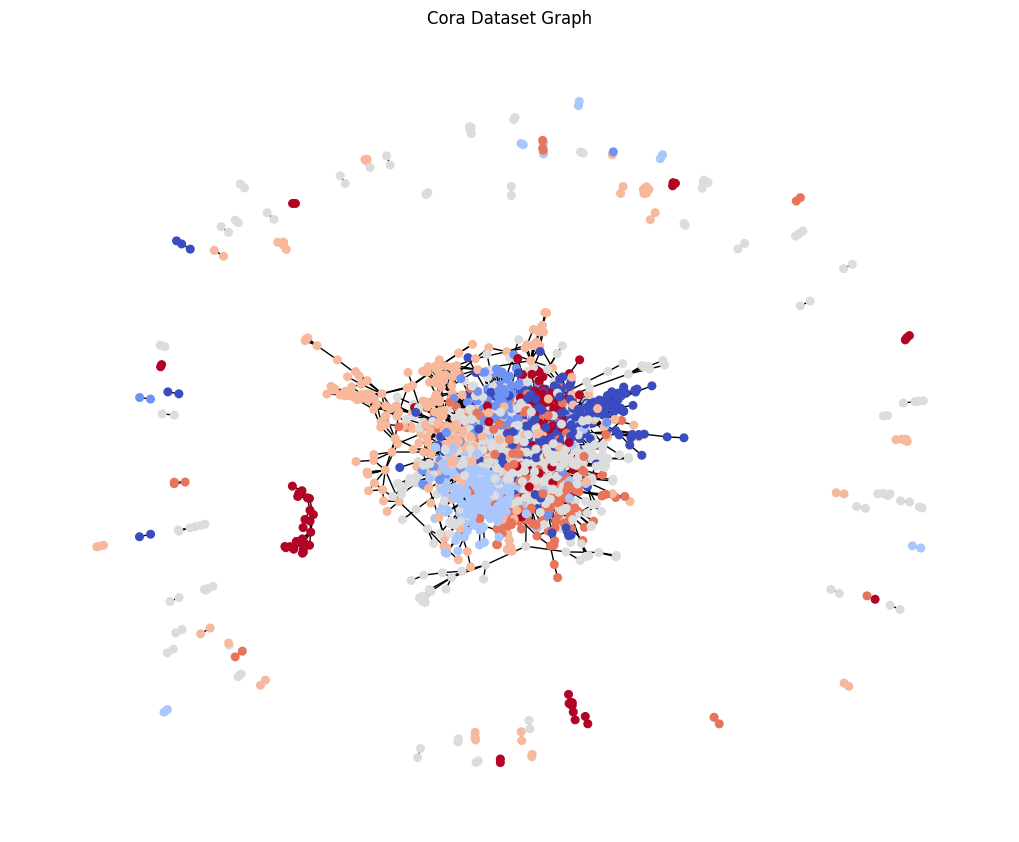

In [12]:
# Install necessary libraries
!pip install torch_geometric torch torch_scatter torch_sparse torch_cluster -q

import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

# Load the Cora dataset
dataset = Planetoid(root="/tmp/Cora", name="Cora", transform=T.NormalizeFeatures())
data = dataset[0]

# Visualize the graph
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10, 8))
nx.draw(G, node_size=30, node_color=data.y, cmap="coolwarm")
plt.title("Cora Dataset Graph")
plt.show()

## Traditional Graph Embedding Methods and Their Limitations
Traditional embeddings, like node2vec, use random walks to generate embeddings based on static graph structure. This approach doesn’t generalize to new nodes effectively, especially in dynamic graphs.

Epoch 0, Loss: 1.9470, Accuracy: 0.0714
Epoch 10, Loss: 1.6978, Accuracy: 0.9000
Epoch 20, Loss: 1.2560, Accuracy: 0.9643
Epoch 30, Loss: 0.8116, Accuracy: 0.9786
Epoch 40, Loss: 0.5282, Accuracy: 0.9786


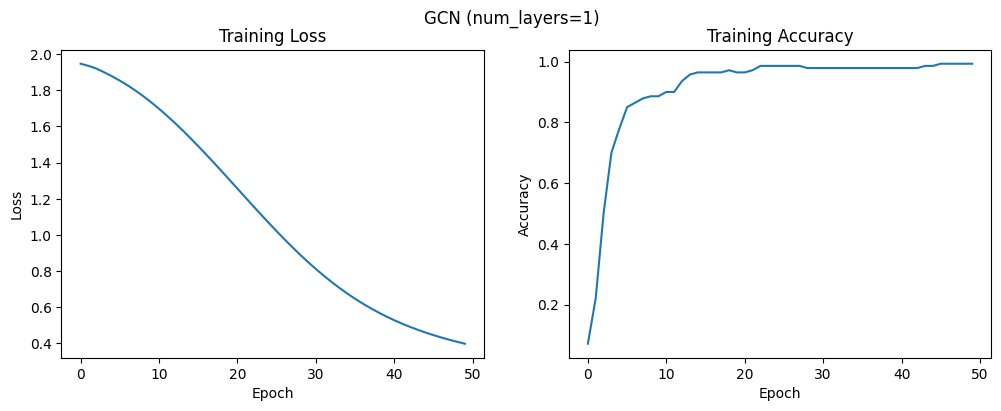

In [29]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple GCN model with flexible layers
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(GCN, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        ...
        
        # Hidden layers
        ...
        
        # Output layer
        ...

    def forward(self, x, edge_index):
        for layer in self.layers[:-1]:
            x = layer(x, edge_index).relu()
        return self.layers[-1](x, edge_index)
    
def train(model, data, optimizer, epochs=50):
    model.train()
    history = {'loss': [], 'accuracy': []}
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        # Initialize the optimizer
        ...
        out = model(data.x, data.edge_index)
        # Remember the train mask
        loss = ...
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, pred = out[data.train_mask].max(dim=1)
        correct = (pred == data.y[data.train_mask]).sum()
        accuracy = correct / data.train_mask.sum()
        
        # Log loss and accuracy
        history['loss'].append(loss.item())
        history['accuracy'].append(accuracy.item())
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
    
    return history

# Parameters
NUM_LAYERS = 3
HIDDEN_CHANNELS = 64
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4

# Initialize model, optimizer
model = GCN(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Train and capture history
history = train(model, data, optimizer)

# Plotting function
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot loss
    ax1.plot(history['loss'], label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    
    # Plot accuracy
    ax2.plot(history['accuracy'], label='Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training Accuracy')
    
    plt.suptitle(title)
    plt.show()

# Plot training results
plot_history(history, f"GCN (num_layers={NUM_LAYERS})")

## Towards an Inductive Solution with GraphSAGE
For graphs that change over time, we need embeddings that adapt to new nodes without retraining. GraphSAGE achieves this by aggregating information from each node’s neighborhood, which generalizes well even as the graph structure evolves.

## GraphSAGE: Sampling and Aggregation
In GraphSAGE, each node's embedding is created by aggregating information from its local neighborhood. Let’s break down this process mathematically.

### 1. Sampling
For each node $v$, we sample a fixed number of neighbors. Let $N(v)$ represent the neighbors of node $v$. Instead of using all neighbors, we take a random sample $N_k(v) \subset N(v)$ to reduce computation.

### 2. Aggregation
For each node $v$, we aggregate the embeddings of its neighbors:
$$
h_{N(v)}^k = f_k(h_{u}^{k-1} \text{ for all } u \in N_k(v))
$$
where $f_k$ is an aggregation function (such as mean or max pooling) that combines information from $N_k(v)$ to form $h_{N(v)}^k$.

### 3. Update
Finally, we update each node’s embedding by combining its own embedding and the aggregated neighborhood information:
$$
h_v^k = \sigma\left(W^k \cdot [h_v^{k-1} \parallel h_{N(v)}^k]\right)
$$
where $W^k$ is a weight matrix, $\sigma$ is a non-linear activation function (such as ReLU), and $\parallel$ denotes concatenation.

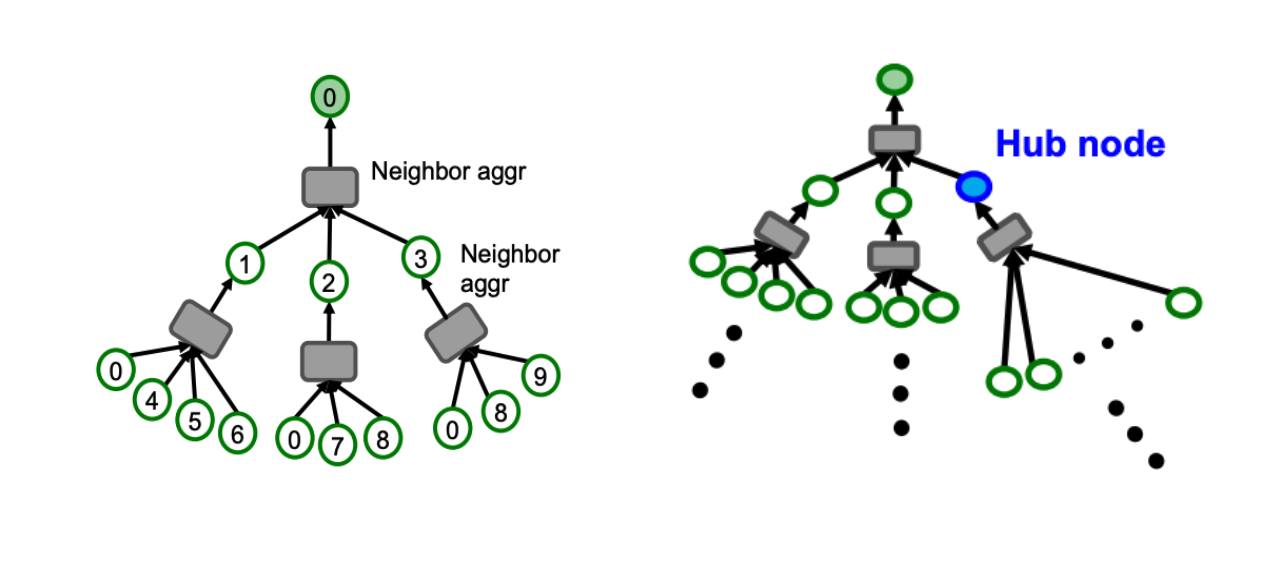z

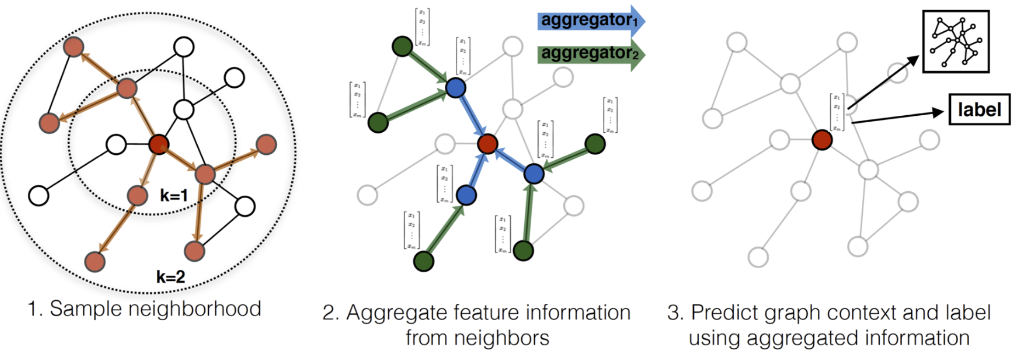

In [26]:
import torch
from torch_geometric.nn import SAGEConv
import torch.nn as nn

class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        # First layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # Aggregation and Update: Second layer
        x = self.conv2(x, edge_index)
        return x

# Initialize model
model = GraphSAGE(input_dim=data.num_features, hidden_dim=64, output_dim=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

Why do we use sampling and aggregation? How does it help in reducing computation while capturing meaningful neighborhood information?

Epoch 0, Loss: 1.9491252899169922
Epoch 10, Loss: 1.2124515771865845
Epoch 20, Loss: 0.21875472366809845
Epoch 30, Loss: 0.021721433848142624
Epoch 40, Loss: 0.0043450649827718735


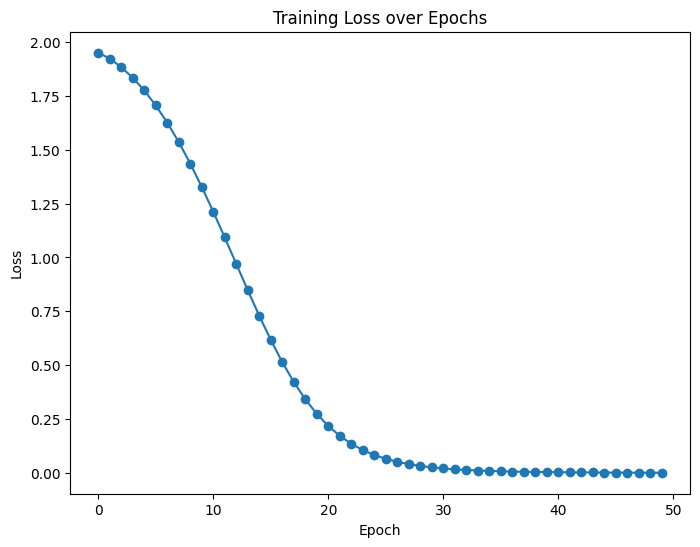

In [15]:
# Training function for GraphSAGE
def train_step(data):
    ...
    return loss.item()

# Train and log loss
losses = []
for epoch in range(50):
    loss = train_step(data)
    losses.append(loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(range(50), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

### Aggregation Methods
GraphSAGE uses different ways to aggregate neighborhood information, each capturing unique aspects of the local neighborhood structure.

1. **Mean Aggregator**:
$$
h_v^k = \sigma(W \cdot \text{MEAN}\left( \{ h_v^{k-1} \} \cup \{ h_u^{k-1} \mid u \in N(v) \} \right))
$$

2. **Pooling Aggregator**:
$$
h_v^k = \max\left(\left\{ \sigma\left(W_{\text{pool}} h_{u}^{k} + b \right) \mid u \in N(v) \right\}\right)
$$

Each method has its benefits: mean aggregators capture average neighborhood characteristics, while max pooling focuses on prominent features.

In [21]:
from torch_geometric.nn import SAGEConv
import torch.nn as nn

class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, aggregation="mean"):
        super(GraphSAGE, self).__init__()
        self.conv1 = ...
        self.conv2 = ...

    def forward(self, x, edge_index):
        # conv -> relu -> conv
        ...
        return x

def train_model(model, data, optimizer, criterion, epochs=50):
    model.train()
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        ...
        
        # Calculate loss
        ...
        
        # Track loss
        losses.append(loss.item())
        
        # Calculate accuracy
        ...
        accuracies.append(accuracy)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
    
    return losses, accuracies

# Model with mean aggregation
mean_model = GraphSAGE(input_dim=data.num_features, hidden_dim=64, output_dim=dataset.num_classes, aggregation="mean")
optimizer_mean = torch.optim.Adam(mean_model.parameters(), lr=0.01)

# Model with max aggregation
max_model = GraphSAGE(input_dim=data.num_features, hidden_dim=64, output_dim=dataset.num_classes, aggregation="max")
optimizer_max = torch.optim.Adam(max_model.parameters(), lr=0.01)

# Train both models and store losses and accuracies
mean_losses, mean_accuracies = train_model(mean_model, data, optimizer_mean, criterion)
max_losses, max_accuracies = train_model(max_model, data, optimizer_max, criterion)

Epoch 0, Loss: 1.9474, Accuracy: 0.1571
Epoch 10, Loss: 1.2936, Accuracy: 1.0000
Epoch 20, Loss: 0.2707, Accuracy: 1.0000
Epoch 30, Loss: 0.0260, Accuracy: 1.0000
Epoch 40, Loss: 0.0048, Accuracy: 1.0000
Epoch 0, Loss: 1.9509, Accuracy: 0.1071
Epoch 10, Loss: 0.6680, Accuracy: 0.9714
Epoch 20, Loss: 0.0497, Accuracy: 1.0000
Epoch 30, Loss: 0.0036, Accuracy: 1.0000
Epoch 40, Loss: 0.0008, Accuracy: 1.0000


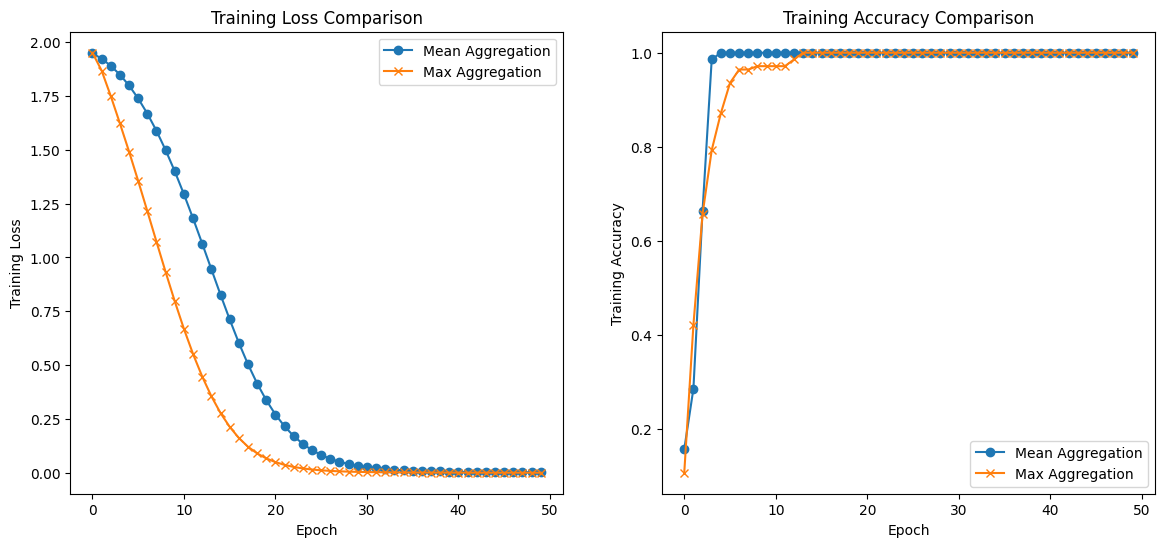

In [22]:
# Plot loss and accuracy for both aggregation methods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot loss
ax1.plot(mean_losses, label="Mean Aggregation", marker='o')
ax1.plot(max_losses, label="Max Aggregation", marker='x')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Training Loss")
ax1.set_title("Training Loss Comparison")
ax1.legend()

# Plot accuracy
ax2.plot(mean_accuracies, label="Mean Aggregation", marker='o')
ax2.plot(max_accuracies, label="Max Aggregation", marker='x')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Training Accuracy")
ax2.set_title("Training Accuracy Comparison")
ax2.legend()

plt.show()

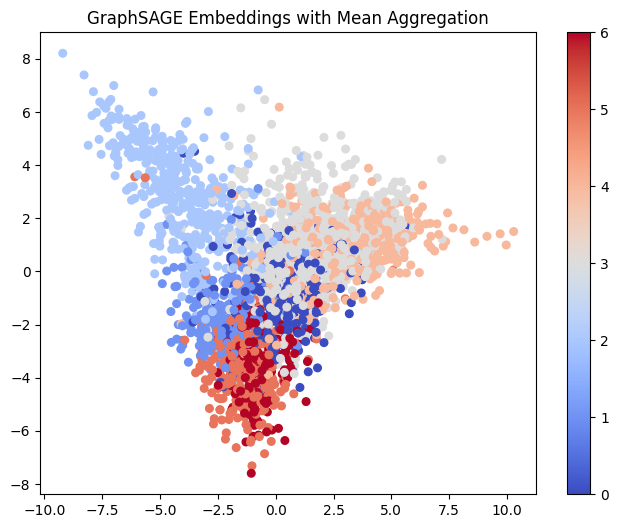

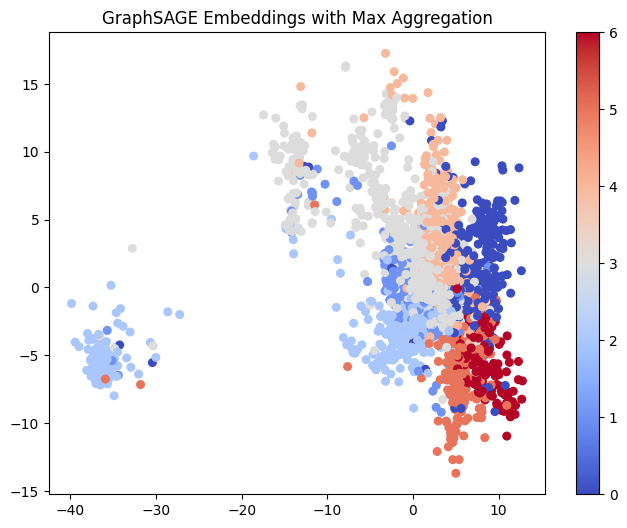

In [23]:
from sklearn.decomposition import PCA

# Function to visualize embeddings
def visualize_embeddings(model, data, title):
    model.eval()
    with torch.no_grad():
        embeddings = model(data.x, data.edge_index)
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings.numpy())
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y, cmap="coolwarm", s=30)
    plt.colorbar()
    plt.title(title)
    plt.show()

# Visualize embeddings for mean and max aggregation
visualize_embeddings(mean_model, data, "GraphSAGE Embeddings with Mean Aggregation")
visualize_embeddings(max_model, data, "GraphSAGE Embeddings with Max Aggregation")

# GraphSAGE: L2 Normalization

Epoch 0, Loss: 4.2052, Accuracy: 0.0000
Epoch 10, Loss: 3.3360, Accuracy: 1.0000
Epoch 20, Loss: 3.2054, Accuracy: 1.0000
Epoch 30, Loss: 3.1891, Accuracy: 1.0000
Epoch 40, Loss: 3.1816, Accuracy: 1.0000


<Figure size 1200x400 with 0 Axes>

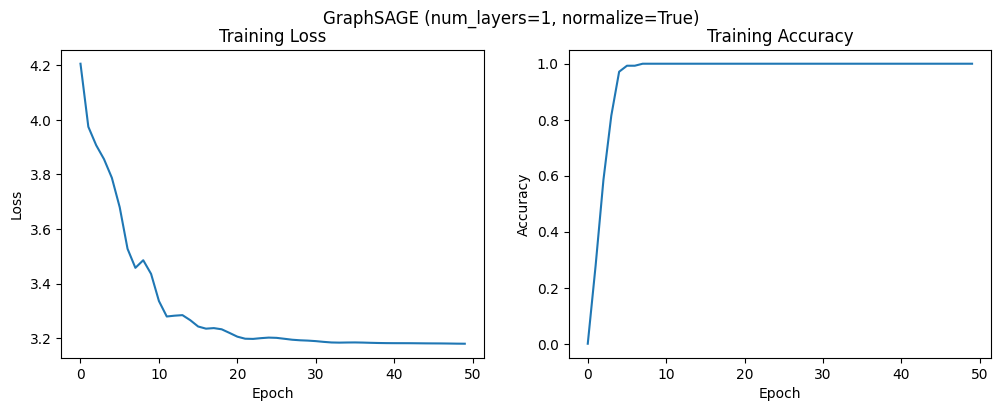

In [27]:
from torch_geometric.nn import GraphSAGE

NUM_LAYERS = 1
NORMALIZE = True


model = GraphSAGE(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, normalize=NORMALIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GraphSAGE (num_layers={NUM_LAYERS}, normalize={NORMALIZE})")

## Reflection
- *How did GraphSAGE address the limitations of traditional embeddings?*
- *What did you observe when changing the aggregation method?*

### Further Exploration
- Experiment with different aggregation methods (mean, max) to observe changes in embedding quality.
- Try applying the model to other datasets to see how well it generalizes.